In [3]:
pip install snowflake-connector-python

     |████████████████████████████████| 16.4 MB 7.5 MB/s            
     |████████████████████████████████| 2.3 MB 57.7 MB/s            
     |████████████████████████████████| 194 kB 109.0 MB/s            
     |████████████████████████████████| 105 kB 122.2 MB/s            
  Attempting uninstall: asn1crypto
    Found existing installation: asn1crypto 1.4.0
    Uninstalling asn1crypto-1.4.0:
      Successfully uninstalled asn1crypto-1.4.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import calendar
from datetime import date
import datetime
from calendar import monthrange
import calendar
import numpy as np
import re
import string
from matplotlib import pyplot

import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
import getpass
import os
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
#from sklearn.utils import check_arrays
#import sklearn.utils as utils
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import random
from dateutil.relativedelta import *
import time

In [5]:
#connect to fivetran DB

con = snowflake.connector.connect(
    user='LITA',
    password=getpass.getpass(prompt='Password: ', stream=None),
    account='tga60420',
    warehouse='COMPUTE_WH',
    database='FIVETRAN_DATABASE',
    schema='TEMP'
)

Password: ········


In [3]:
#connect to analyst db

con_w = snowflake.connector.connect(
    user='LITA',
    password=getpass.getpass(prompt='Password: ', stream=None),
    account='tga60420',
    warehouse='COMPUTE_WH',
    database='ANALYST',
    schema='TEMP'
)

Password: ········


# Params

In [9]:
shift = 8 #how many days after 1st i.e. if ran on 4th, then shift = 3
n = 50 #number of bootstramp iteration
start_ind = 24 #start index for change period (for ROAS calc)
end_ind = -12 #stop index for change period (for ROAS calc)

In [10]:
#dates
today_a = datetime.date.today().strftime("%Y-%m-%d")#today
m_p = (datetime.date.today() - relativedelta(days=datetime.date.today().day)).month #previous month
y_p = (datetime.date.today() - relativedelta(days=datetime.date.today().day)).year #year of previous month

end_date = (datetime.date.today() - relativedelta(days=datetime.date.today().day)).strftime("%Y-%m-%d")
start_date_modeling = ((datetime.date.today() 
                        - relativedelta(days=datetime.date.today().day)) 
                       - relativedelta(months=15)).strftime("%Y-%m-%d")
start_date = ((datetime.date.today() 
                        - relativedelta(days=datetime.date.today().day)) 
                       - relativedelta(months=15) - relativedelta(months=4)).strftime("%Y-%m-%d")

In [11]:
#set seed
seed = 52
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [12]:
end_date

'2022-12-31'

In [13]:
start_date_modeling

'2021-09-30'

In [14]:
start_date

'2021-05-30'

# Get data

## training data

In [18]:
#training data query

query = query = f"""
SELECT DATE_AT
     , cal.MONTHNAME
     , cal.ISHOLIDAY
     , steelhouse_p.STEELHOUSE_PROSPECTING_IMP AS STEELHOUSE_PROSPECTING
     , steelhouse_r.STEELHOUSE_RETARGETING_IMP AS STEELHOUSE_RETARGETING
     , adwords_lump.ADWORDS_LUMP_IMP AS ADWORDS_LUMP
     , adwords_yt.adwords_yt_imp AS ADWORDS_YT
     , adwords_search.ADWORDS_SEARCH_IMP AS ADWORDS_SEARCH
     , perfmax.PERFMAX_IMP AS PERFMAX
     , bing.BING_IMP AS BING
     , fb.FB_RETARGETING_IMP AS FB_RETARGETING
     , fb.FB_PROSPECTING_IMP AS FB_PROSPECTING
     , hubspot.OPENS_EMAIL
     , pod.PODCAST_IMP * 1.00 AS PODCAST
     , yt_shows.YOUTUBE_SHOWS_IMP AS YOUTUBE_SHOWS
     , pub.IMPRESSIONS_ONLINE_PUBS
     , org.IMPRESSIONS_BRANDED_SEARCH
     , org.IMPRESSIONS_NONBRANDED_SEARCH
     , reg.NEW_VEHICLE_SALES
     , reg.USED_VEHICLE_SALES
     , g_search.total AS SEARCH_INDEX
     , linktree.linktree_sessions
     , aov.aov
--   , govx
--   , inflation
     , product_launch.PRODUCT_LAUNCH
     , major_changes.CHANGES
     , avg_pos SERP
     , sales.SALES
FROM CALENDAR..V_CALENDAR_DIM cal

-- STEELHOUSE - prospecting
         LEFT JOIN (
    SELECT DAY
         , SUM(SPEND) STEELHOUSE_PROSPECTING
         , SUM(IMPRESSIONS) STEELHOUSE_PROSPECTING_IMP
    FROM FIVETRAN_DATABASE.AWS_LAMBDA.CAMPAIGN_GROUP
    WHERE lower(NAME) not like '%retargeting%'
    GROUP BY 1
) steelhouse_p
                   ON cal.DATE_AT = steelhouse_p.DAY

-- STEELHOUSE - retargeting
         LEFT JOIN (
    SELECT DAY
         , SUM(SPEND) STEELHOUSE_RETARGETING
         , SUM(IMPRESSIONS) STEELHOUSE_RETARGETING_IMP
    FROM FIVETRAN_DATABASE.AWS_LAMBDA.CAMPAIGN_GROUP
    WHERE lower(NAME) like '%retargeting%'
    GROUP BY 1
) steelhouse_r
                   ON cal.DATE_AT = steelhouse_r.DAY

-- GOOGLE YOUTUBE
--         LEFT JOIN (
--    SELECT DATE
--         , SUM(COST) YOUTUBE
--         , SUM(IMPRESSIONS) YOUTUBE_IMP
--    FROM YOUTUBE.AD_PERFORMANCE
--    WHERE ((rlike(lower(CAMPAIGN_NAME), '.*_yt_.*')
--        OR NOT rlike(lower(CAMPAIGN_NAME), '.*discovery.*|.*display.*'))
--        AND DATE >= '2020-05-31')
--      AND CAMPAIGN_NAME <> 'RETARGETING-DISCOVERY_yt_decked_retargeting_bottom_purchase'
--    GROUP BY 1
--) yt
--                   ON cal.DATE_AT = yt.DATE

-- GOOGLE DISPLAY
--         LEFT JOIN (
--    SELECT DATE
--         , SUM(COST) DISPLAY
--         , SUM(IMPRESSIONS) DISPLAY_IMP
--    FROM YOUTUBE.AD_PERFORMANCE
--    WHERE (NOT rlike(lower(CAMPAIGN_NAME), '.*_yt_.*')
--        AND rlike(lower(CAMPAIGN_NAME), '.*discovery.*|.*display.*'))
--       OR CAMPAIGN_NAME = 'RETARGETING-DISCOVERY_yt_decked_retargeting_bottom_purchase'
--    GROUP BY 1
--) display
--                   ON cal.DATE_AT = display.DATE

-- GOOGLE SEARCH (ADWORDS)
--         LEFT JOIN (
--    SELECT DATE
--        , SUM(COST) ADWORDS
--        , SUM(CASE WHEN AD_TYPE NOT IN ('VIDEO_TRUEVIEW_IN_STREAM_AD', 'VIDEO_RESPONSIVE_AD', 'EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD') THEN IMPRESSIONS) ADWORDS_LUMP_IMP
--        , SUM(CASE WHEN AD_TYPE IN ('VIDEO_TRUEVIEW_IN_STREAM_AD', 'VIDEO_RESPONSIVE_AD') THEN IMPRESSIONS) ADWORDS_VIDEO_IMP
--        , SUM(CASE WHEN AD_TYPE IN ('EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD') THEN IMPRESSIONS) ADWORDS_SEARCH_IMP
--    FROM FIVETRAN_DATABASE.ADWORDS.AD_PERFORMANCE
--    WHERE DATE >= '2021-02-01'
--    AND DATE < '2021-03-01'
--    GROUP BY 1

--    UNION

--    SELECT DATE
--        , SUM(COST_MICROS)*0.000001 ADWORDS
--        , SUM(CASE WHEN AD_TYPE NOT IN ('VIDEO_TRUEVIEW_IN_STREAM_AD', 'VIDEO_RESPONSIVE_AD', 'EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD') THEN IMPRESSIONS) ADWORDS_LUMP_IMP
--        , SUM(CASE WHEN AD_TYPE IN ('VIDEO_TRUEVIEW_IN_STREAM_AD', 'VIDEO_RESPONSIVE_AD') THEN IMPRESSIONS) ADWORDS_VIDEO_IMP
--        , SUM(CASE WHEN AD_TYPE IN ('EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD') THEN IMPRESSIONS) ADWORDS_SEARCH_IMP
--    FROM FIVETRAN_DATABASE.ADWORDS_NEW_API_2.AD_PERFORMANCE
--    WHERE DATE >= '2021-03-01'
--    GROUP BY 1
--) adwords
--                   ON cal.DATE_AT = adwords.DATE

-- ADWORDS LUMP
        LEFT JOIN (
    WITH C AS (
    SELECT DATE
        , COALESCE(SUM(CASE WHEN AD_TYPE NOT IN ('VIDEO_TRUEVIEW_IN_STREAM_AD', 'VIDEO_RESPONSIVE_AD', 'EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD') THEN (COST_MICROS*0.000001) ELSE NULL END), 0) ADWORDS_LUMP
        , COALESCE(SUM(CASE WHEN AD_TYPE NOT IN ('VIDEO_TRUEVIEW_IN_STREAM_AD', 'VIDEO_RESPONSIVE_AD', 'EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD') THEN IMPRESSIONS ELSE NULL END), 0) ADWORDS_LUMP_IMP
    FROM FIVETRAN_DATABASE.ADWORDS_NEW_API_2.AD_PERFORMANCE
    GROUP BY 1
    ),
    D AS (
    SELECT DATE
         , COALESCE(SUM(COST), 0) ADWORDS_LUMP
         , COALESCE(SUM(IMPRESSIONS), 0) ADWORDS_LUMP_IMP
    FROM FIVETRAN_DATABASE.YOUTUBE.AD_PERFORMANCE
    WHERE ((NOT rlike(lower(CAMPAIGN_NAME), '.*_yt_.*')
        AND rlike(lower(CAMPAIGN_NAME), '.*discovery.*|.*display.*'))
        OR CAMPAIGN_NAME = 'RETARGETING-DISCOVERY_yt_decked_retargeting_bottom_purchase')
        AND date < '2021-09-08'
    GROUP BY 1
    )
    SELECT C.DATE
         , COALESCE(C.ADWORDS_LUMP_IMP, 0) + COALESCE(D.ADWORDS_LUMP_IMP, 0) ADWORDS_LUMP_IMP
         , COALESCE(C.ADWORDS_LUMP, 0) + COALESCE(D.ADWORDS_LUMP, 0) ADWOR5DS_LUMP
    FROM C
    LEFT JOIN D ON (C.DATE = D.DATE)
    ORDER BY 1
) adwords_lump
                   ON cal.DATE_AT = adwords_lump.DATE

-- ADWORDS YT
        LEFT JOIN (
    SELECT DATE
         , SUM(IMPRESSIONS) ADWORDS_YT_IMP
    FROM YOUTUBE.AD_PERFORMANCE
    WHERE ((rlike(lower(CAMPAIGN_NAME), '.*_yt_.*')
        OR NOT rlike(lower(CAMPAIGN_NAME), '.*discovery.*|.*display.*'))
        AND DATE >= '2020-05-31'
        AND DATE < '2021-09-08')
        AND CAMPAIGN_NAME <> 'RETARGETING-DISCOVERY_yt_decked_retargeting_bottom_purchase'
    GROUP BY 1

    UNION

    SELECT DATE
        , SUM(CASE WHEN AD_TYPE IN ('VIDEO_TRUEVIEW_IN_STREAM_AD', 'VIDEO_RESPONSIVE_AD') THEN IMPRESSIONS ELSE NULL END) ADWORDS_YT_IMP
    FROM FIVETRAN_DATABASE.ADWORDS_NEW_API_2.AD_PERFORMANCE
    WHERE DATE >= '2021-09-08'
    GROUP BY 1
) adwords_yt
                   ON cal.DATE_AT = adwords_yt.DATE

-- ADWORDS SEARCH
        LEFT JOIN (
    SELECT DATE
        , SUM(CASE WHEN AD_TYPE IN ('EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD') THEN IMPRESSIONS ELSE NULL END) ADWORDS_SEARCH_IMP
    FROM FIVETRAN_DATABASE.ADWORDS_NEW_API_2.AD_PERFORMANCE
    GROUP BY 1
) adwords_search
                   ON cal.DATE_AT = adwords_search.DATE

-- GOOGLE PERFMAX
         LEFT JOIN (
    SELECT DATE
        , SUM(COST_MICROS)*0.000001 PERFMAX
        , SUM(IMPRESSIONS) PERFMAX_IMP
    FROM FIVETRAN_DATABASE.ADWORDS_NEW_API.CAMPAIGN_COST
    WHERE name like '%PERFORMANCE-MAX%'
    GROUP BY DATE
) perfmax
                   ON cal.DATE_AT = perfmax.DATE

-- BING SEARCH
         LEFT JOIN (
    SELECT DATE
         , SUM(SPEND) BING
         , SUM(IMPRESSIONS) BING_IMP
    FROM BING.CAMPAIGN_PERFORMANCE_DAILY_REPORT
    GROUP BY 1
) bing
                   ON cal.DATE_AT = bing.DATE

-- FACEBOOK
         LEFT JOIN (
    SELECT DATE
         , SUM(CASE WHEN lower(CAMPAIGN_GA) like '%retargeting%' THEN SPEND END) FB_RETARGETING
         , SUM(CASE WHEN lower(CAMPAIGN_GA) like '%retargeting%' THEN IMPRESSIONS END) FB_RETARGETING_IMP
         , SUM(CASE WHEN lower(CAMPAIGN_GA) like '%prospecting%' THEN SPEND END) FB_PROSPECTING
         , SUM(CASE WHEN lower(CAMPAIGN_GA) like '%prospecting%' THEN IMPRESSIONS END) FB_PROSPECTING_IMP
    FROM FACEBOOK.ADS s1
             JOIN FACEBOOK.V_AD_UTM_MAP s2
                  ON s1.AD_ID = s2.AD_ID
                      AND s1.DATE = s2.DATE_AT
    GROUP BY 1
) fb
                   ON cal.DATE_AT = fb.DATE

-- EMAIL
         LEFT JOIN (
    SELECT DATE(CREATED)                                   DATE
        , COUNT(CASE WHEN TYPE = 'DELIVERED' THEN ID END)  SENDS_EMAIL
        , COUNT(CASE WHEN TYPE = 'CLICK' THEN ID END)      CLICKS_EMAIL
        , COUNT(CASE WHEN TYPE = 'OPEN' THEN ID END)       OPENS_EMAIL
    FROM HUBSPOT.EMAIL_EVENT
    GROUP BY 1
) hubspot
                   ON cal.DATE_AT = hubspot.DATE


-- PODCASTS
         LEFT JOIN (
    SELECT DATE(BROADCAST_WEEK)        WEEK
         , SUM(GROSS_SPEND * 1.00 / 7) PODCAST
         , SUM(GROSS_IMPRESSIONS * 1.00 / 7) PODCAST_IMP
    FROM GOOGLE_SHEETS.VERITONE_PODCAST_PERFORMANCE
    WHERE MEDIA_TYPE = 'Podcast'
    GROUP BY 1
) pod
                   ON cal.FIRSTDAYOFWEEK = pod.WEEK

-- YOUTUBE SHOWS
         LEFT JOIN (
    SELECT DATE(BROADCAST_WEEK)        WEEK
         , SUM(GROSS_SPEND * 1.00 / 7) YOUTUBE_SHOWS
         , SUM(GROSS_IMPRESSIONS * 1.00 / 7) YOUTUBE_SHOWS_IMP
    FROM GOOGLE_SHEETS.VERITONE_PODCAST_PERFORMANCE
    WHERE MEDIA_TYPE = 'YouTube'
    GROUP BY 1
) yt_shows
                   ON cal.FIRSTDAYOFWEEK = yt_shows.WEEK

-- ONLINE PUBLICATIONS
         LEFT JOIN (
    SELECT DATE(DATE) DATE
         , SUM(AUDIENCE)   IMPRESSIONS_ONLINE_PUBS
    FROM fivetran_database.GOOGLE_SHEETS.ONLINE_MEDIA_PARTNER
    WHERE DATE IS NOT NULL
    GROUP BY 1
) pub
                   ON cal.DATE_AT = pub.DATE

-- ORGANIC SEARCH
         LEFT JOIN (
    SELECT DATE
         , SUM(CASE
                   WHEN (lower(KEYWORD) LIKE '%deck%' or lower(KEYWORD) LIKE '%cargoglide%' or lower(KEYWORD) LIKE '%cargo glide%')
                       THEN IMPRESSIONS END) IMPRESSIONS_BRANDED_SEARCH
         , SUM(CASE
                   WHEN NOT (lower(KEYWORD) LIKE '%deck%' or lower(KEYWORD) LIKE '%cargoglide%' or lower(KEYWORD) LIKE '%cargo glide%')
                       THEN IMPRESSIONS END) IMPRESSIONS_NONBRANDED_SEARCH
    FROM GOOGLE_SEARCH_CONSOLE.KEYWORD_SITE_REPORT_BY_SITE
    GROUP BY 1
) org
                   ON cal.DATE_AT = org.DATE
-- SHOPIFY REV
         LEFT JOIN (
    SELECT DATE(CREATED_AT)     DATE_SALES
         , SUM(TOTAL_PRICE_USD) SALES
    FROM SHOPIFY."ORDER"
    GROUP BY 1
) sales
                   ON cal.DATE_AT = sales.DATE_SALES

-- TRUCK SALES
         LEFT JOIN (
SELECT DATE_a as DATE
     , SUM(CASE WHEN NEW_USED = 'NEW' THEN VEHICLE_COUNT * 1.00 / DAY(LAST_DAY(DATE_a)) END)  NEW_VEHICLE_SALES
     , SUM(CASE WHEN NEW_USED = 'USED' THEN VEHICLE_COUNT * 1.00 / DAY(LAST_DAY(DATE_a)) END) USED_VEHICLE_SALES
FROM (SELECT *
           , DATE(LEFT(REPORT_YEAR_MONTH, 4) || '-'
        || RIGHT(REPORT_YEAR_MONTH, 2) || '-01') DATE_a
      FROM ANALYST.VEHICLE_REGISTRATIONS.REGISTRATIONS
     )
GROUP BY 1

) reg
                   ON cal.FIRSTDAYOFMONTH = reg.DATE
-- EMAIL REVENUE
--    LEFT JOIN (
--    select date
--     , sum(TRANSACTIONREVENUE) as email_rev
--    from FIVETRAN_DATABASE.GOOGLE_ANALYTICS.V_ACQUISITION_GOALS
--    where medium = 'email'
--    group by 1
--) email_rev

--                ON cal.DATE_AT = email_rev.DATE

-- LINKTREE
    LEFT JOIN (
    select date
     , sum(SESSIONS) as linktree_sessions
    from FIVETRAN_DATABASE.GOOGLE_ANALYTICS.V_ACQUISITION_GOALS
    where source = 'linktree'
    group by 1
) linktree

              ON cal.DATE_AT = linktree.DATE

--ORGANIC CLICKS
--    LEFT JOIN (
--    SELECT Date
--    , SUM(CLICKS) AS CLICKS_ORGANIC
--    FROM FIVETRAN_DATABASE.GOOGLE_SEARCH_CONSOLE.KEYWORD_SITE_REPORT_BY_SITE
--    GROUP BY 1
--) organic

--                ON cal.DATE_AT = organic.DATE

--SERP
    LEFT JOIN (
    SELECT date, pos_avg_num / pos_avg_den AS avg_pos
    FROM
    (SELECT DATE
         , SUM(position_mul) AS pos_avg_num
         , SUM(IMPRESSIONS) AS pos_avg_den
    FROM (SELECT DATE, IMPRESSIONS, IMPRESSIONS*POSITION AS position_mul FROM FIVETRAN_DATABASE.GOOGLE_SEARCH_CONSOLE.SITE_REPORT_BY_SITE)
    GROUP BY 1)
) serp

                ON cal.DATE_AT = serp.DATE

--AOV
    LEFT JOIN (
    SELECT date, shopify_dtc_rev/shopify_order_count as AOV
    FROM
    (SELECT date(CREATED_AT) date
         , count(distinct id) shopify_order_count
         , sum(TOTAL_PRICE_USD) shopify_dtc_rev
    FROM FIVETRAN_DATABASE.SHOPIFY."ORDER"
    GROUP BY 1)
) aov
                ON aov.date = cal.DATE_AT

--GOVX
--    LEFT JOIN(
--    SELECT date(CREATED_AT) date
--    ,sum(TOTAL_PRICE_USD) shopify_dtc_rev_govx
--    FROM FIVETRAN_DATABASE.SHOPIFY."ORDER" c
--    LEFT JOIN FIVETRAN_DATABASE.SHOPIFY.ORDER_DISCOUNT_CODE e on (e.ORDER_ID = c.id)
--    WHERE E.CODE like '%GX-%'
--    GROUP BY 1
--) GOVX

--               ON cal.DATE_AT = govx.date

--SEARCH INDEX
    LEFT JOIN (
    SELECT CAST(date AS DATE) AS Date
         , TOTAL
    FROM FIVETRAN_DATABASE.GOOGLE_SHEETS.g_search_index
) g_search
                ON cal.DATE_AT = g_search.Date

--PRODUCT LAUNCH
    LEFT JOIN (
    SELECT DATE
        , PRODUCT_LAUNCH
    from FIVETRAN_DATABASE.GOOGLE_SHEETS.mmm_new_product_launch
) product_launch
                ON cal.DATE_AT = product_launch.Date

--MAJOR CHANGES
    LEFT JOIN (
    SELECT DATE
        , CHANGES
    from FIVETRAN_DATABASE.GOOGLE_SHEETS.mmm_major_changes
) major_changes
                ON cal.DATE_AT = major_changes.Date


WHERE DATE_AT >= '2019-04-01'
ORDER BY DATE_AT
"""

cur = con.cursor()
cur.execute(query)

In [19]:
# get training data

df_sql = cur.fetchall()
df = df_sql.copy()
df = pd.DataFrame(df)
cols = ['DATE_AT', 'MONTHNAME', 'ISHOLIDAY', 'STEELHOUSE_PROSPECTING', 'STEELHOUSE_RETARGETING', 
        'ADWORDS_LUMP', 'ADWORDS_YT', 'ADWORDS_SEARCH', 'PERFMAX', 'BING', 'FB_RETARGETING', 'FB_PROSPECTING',
       'OPENS_EMAIL', 'PODCAST', 'YOUTUBE_SHOWS', 'IMPRESSIONS_ONLINE_PUBS',
       'IMPRESSIONS_BRANDED_SEARCH','IMPRESSIONS_NONBRANDED_SEARCH','NEW_VEHICLE_SALES','USED_VEHICLE_SALES',
       'SEARCH_INDEX', 'LINKTREE_SESSION', 'AOV', 'PRODUCT_LAUNCH', 'MAJOR_CHANGES', 'SERP','SALES']
df.columns = cols
df['PERFMAX'] = df['PERFMAX'].astype('float64')
df['PODCAST'] = df['PODCAST'].astype('float64')
df['YOUTUBE_SHOWS'] = df['YOUTUBE_SHOWS'].astype('float64')
df['NEW_VEHICLE_SALES'] = df['NEW_VEHICLE_SALES'].astype('float64')
df['USED_VEHICLE_SALES'] = df['USED_VEHICLE_SALES'].astype('float64')
df['DATE_AT'] = pd.to_datetime(df['DATE_AT'])
df = df.loc[(df['DATE_AT']>=start_date) & (df['DATE_AT']<=end_date), :]

In [20]:
df['DATE_AT'].min()

Timestamp('2021-04-30 00:00:00')

In [21]:
df['DATE_AT'].max()

Timestamp('2022-11-30 00:00:00')

In [22]:
# imputing

df['USED_VEHICLE_SALES'] = df['USED_VEHICLE_SALES'].fillna(df['USED_VEHICLE_SALES'].mean())
df['NEW_VEHICLE_SALES'] = df['NEW_VEHICLE_SALES'].fillna(df['NEW_VEHICLE_SALES'].mean())

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 580 entries, 760 to 1339
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   DATE_AT                        580 non-null    datetime64[ns]
 1   MONTHNAME                      580 non-null    object        
 2   ISHOLIDAY                      580 non-null    int64         
 3   STEELHOUSE_PROSPECTING         490 non-null    float64       
 4   STEELHOUSE_RETARGETING         580 non-null    float64       
 5   ADWORDS_LUMP                   580 non-null    float64       
 6   ADWORDS_YT                     563 non-null    float64       
 7   ADWORDS_SEARCH                 580 non-null    float64       
 8   PERFMAX                        358 non-null    float64       
 9   BING                           431 non-null    float64       
 10  FB_RETARGETING                 580 non-null    float64       
 11  FB_PROSPECTING  

In [24]:
#convert to weekly data (date is first day of week)

s = ['ISHOLIDAY', 'STEELHOUSE_PROSPECTING',
       'STEELHOUSE_RETARGETING', 'ADWORDS_LUMP', 'ADWORDS_YT',
       'ADWORDS_SEARCH', 'PERFMAX', 'BING', 'FB_RETARGETING', 'FB_PROSPECTING',
       'OPENS_EMAIL', 'PODCAST', 'YOUTUBE_SHOWS', 'IMPRESSIONS_ONLINE_PUBS',
       'IMPRESSIONS_BRANDED_SEARCH', 'IMPRESSIONS_NONBRANDED_SEARCH',
       'NEW_VEHICLE_SALES', 'USED_VEHICLE_SALES', 'LINKTREE_SESSION', 'PRODUCT_LAUNCH', 'MAJOR_CHANGES', 'SALES']
a = ['SEARCH_INDEX', 'AOV', 'SERP']

df = df.set_index('DATE_AT')
df_s = df[s].resample('W', label='left', closed='left').sum().reset_index()
df_a = df[a].resample('W', label='left', closed='left').mean().reset_index()
df = pd.merge(df_s, df_a, on='DATE_AT')
df['MONTHNAME'] = df['DATE_AT'].dt.strftime("%b")
df = df.sort_values('DATE_AT')
df = df.iloc[1:-1]
df.head()

,DATE_AT,ISHOLIDAY,STEELHOUSE_PROSPECTING,STEELHOUSE_RETARGETING,ADWORDS_LUMP,ADWORDS_YT,ADWORDS_SEARCH,PERFMAX,BING,FB_RETARGETING,FB_PROSPECTING,OPENS_EMAIL,PODCAST,YOUTUBE_SHOWS,IMPRESSIONS_ONLINE_PUBS,IMPRESSIONS_BRANDED_SEARCH,IMPRESSIONS_NONBRANDED_SEARCH,NEW_VEHICLE_SALES,USED_VEHICLE_SALES,LINKTREE_SESSION,PRODUCT_LAUNCH,MAJOR_CHANGES,SALES,SEARCH_INDEX,AOV,SERP,MONTHNAME
1,2021-05-02,0,290769.000,342284.000,21534128.000,1109507.000,112771.000,0.000,56829.000,251301.000,3182405.000,68079.000,0.000,0.000,504451.000,17084.000,253256.000,120848.484,150949.900,481.000,1.000,0.000,688501.810,544.000,1167.988,30.601,May
2,2021-05-09,0,260370.000,306061.000,20483179.000,705663.000,93477.000,0.000,89855.000,256361.000,2795105.000,107061.000,0.000,0.000,30.000,16511.000,244577.000,120848.484,150949.900,602.000,0.000,0.000,606192.040,568.000,1157.866,30.237,May
3,2021-05-16,0,259141.000,301175.000,21142154.000,133360.000,101151.000,0.000,102124.000,244684.000,2340846.000,54884.000,0.000,0.000,1134760.000,17697.000,233952.000,120848.484,150949.900,1604.000,0.000,0.000,608472.040,515.000,1196.102,31.529,May
4,2021-05-23,0,252715.000,288697.000,19841967.000,125030.000,103957.000,0.000,117182.000,302202.000,1949997.000,94299.000,0.000,0.000,0.000,17162.000,223553.000,120848.484,150949.900,744.000,0.000,0.000,556999.020,598.000,1167.326,31.701,May
5,2021-05-30,0,262959.000,289754.000,22074576.000,151783.000,99195.000,0.000,134904.000,300250.000,2066502.000,99041.000,111428.571,0.000,0.000,16634.000,232867.000,119087.486,141843.054,684.000,0.000,0.000,561863.570,509.000,1178.352,31.740,May


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 1 to 82
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   DATE_AT                        82 non-null     datetime64[ns]
 1   ISHOLIDAY                      82 non-null     int64         
 2   STEELHOUSE_PROSPECTING         82 non-null     float64       
 3   STEELHOUSE_RETARGETING         82 non-null     float64       
 4   ADWORDS_LUMP                   82 non-null     float64       
 5   ADWORDS_YT                     82 non-null     float64       
 6   ADWORDS_SEARCH                 82 non-null     float64       
 7   PERFMAX                        82 non-null     float64       
 8   BING                           82 non-null     float64       
 9   FB_RETARGETING                 82 non-null     float64       
 10  FB_PROSPECTING                 82 non-null     float64       
 11  OPENS_EMAIL          

In [26]:
# dummy variables

df = pd.get_dummies(df, columns=['MONTHNAME'])

In [27]:
# standardize

cols_std = ['ISHOLIDAY','STEELHOUSE_PROSPECTING','STEELHOUSE_RETARGETING', 'ADWORDS_LUMP', 'ADWORDS_YT', 'ADWORDS_SEARCH', 'PERFMAX', 
       'BING', 'FB_RETARGETING', 'FB_PROSPECTING', 'OPENS_EMAIL', 'PODCAST', 'YOUTUBE_SHOWS', 'IMPRESSIONS_ONLINE_PUBS',
       'IMPRESSIONS_BRANDED_SEARCH','IMPRESSIONS_NONBRANDED_SEARCH','NEW_VEHICLE_SALES','USED_VEHICLE_SALES',
       'LINKTREE_SESSION', 'PRODUCT_LAUNCH', 'MAJOR_CHANGES','SEARCH_INDEX', 'AOV', 'SERP']

df[cols_std] = MinMaxScaler().fit_transform(df[cols_std]) 

In [28]:
# get lags

df['NEW_VEHICLE_SALES_8'] = df['NEW_VEHICLE_SALES'].shift(8)
df['NEW_VEHICLE_SALES_14'] = df['NEW_VEHICLE_SALES'].shift(14)
df['USED_VEHICLE_SALES_12'] = df['USED_VEHICLE_SALES'].shift(12)
df['USED_VEHICLE_SALES_16'] = df['USED_VEHICLE_SALES'].shift(16)
df['PRODUCT_LAUNCH_8'] = df['PRODUCT_LAUNCH'].shift(8)
df['MAJOR_CHANGES_6'] = df['MAJOR_CHANGES'].shift(6)
df['MAJOR_CHANGES_10'] = df['MAJOR_CHANGES'].shift(10)
df['MAJOR_CHANGES_12'] = df['MAJOR_CHANGES'].shift(12)

In [29]:
# trim date

df = df.loc[(df['DATE_AT']>=start_date_modeling), :]

In [30]:
df.describe()

,ISHOLIDAY,STEELHOUSE_PROSPECTING,STEELHOUSE_RETARGETING,ADWORDS_LUMP,ADWORDS_YT,ADWORDS_SEARCH,PERFMAX,BING,FB_RETARGETING,FB_PROSPECTING,OPENS_EMAIL,PODCAST,YOUTUBE_SHOWS,IMPRESSIONS_ONLINE_PUBS,IMPRESSIONS_BRANDED_SEARCH,IMPRESSIONS_NONBRANDED_SEARCH,NEW_VEHICLE_SALES,USED_VEHICLE_SALES,LINKTREE_SESSION,PRODUCT_LAUNCH,MAJOR_CHANGES,SALES,SEARCH_INDEX,AOV,SERP,MONTHNAME_Apr,MONTHNAME_Aug,MONTHNAME_Dec,MONTHNAME_Feb,MONTHNAME_Jan,MONTHNAME_Jul,MONTHNAME_Jun,MONTHNAME_Mar,MONTHNAME_May,MONTHNAME_Nov,MONTHNAME_Oct,MONTHNAME_Sep,NEW_VEHICLE_SALES_8,NEW_VEHICLE_SALES_14,USED_VEHICLE_SALES_12,USED_VEHICLE_SALES_16,PRODUCT_LAUNCH_8,MAJOR_CHANGES_6,MAJOR_CHANGES_10,MAJOR_CHANGES_12
count,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000,64.000
mean,0.203,0.225,0.425,0.134,0.303,0.645,0.587,0.050,0.330,0.349,0.502,0.122,0.162,0.067,0.395,0.560,0.383,0.535,0.376,0.234,0.635,657633.388,0.474,0.680,0.368,0.062,0.062,0.062,0.062,0.078,0.078,0.062,0.062,0.078,0.109,0.156,0.125,0.366,0.406,0.576,0.610,0.250,0.627,0.621,0.615
std,0.406,0.176,0.263,0.054,0.258,0.152,0.323,0.048,0.191,0.306,0.143,0.170,0.226,0.171,0.166,0.226,0.177,0.205,0.240,0.427,0.210,76307.508,0.192,0.168,0.263,0.244,0.244,0.244,0.244,0.270,0.270,0.244,0.244,0.270,0.315,0.366,0.333,0.188,0.231,0.219,0.221,0.436,0.220,0.225,0.220
min,0.000,0.000,0.000,0.000,0.000,0.364,0.000,0.000,0.000,0.000,0.197,0.000,0.000,0.000,0.116,0.000,0.000,0.000,0.000,0.000,0.000,505256.780,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.039,0.180,0.104,0.118,0.535,0.582,0.000,0.229,0.102,0.407,0.000,0.000,0.000,0.281,0.490,0.284,0.390,0.177,0.000,0.625,591981.637,0.351,0.615,0.172,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.153,0.153,0.390,0.551,0.000,0.625,0.625,0.625
50%,0.000,0.269,0.484,0.139,0.233,0.643,0.700,0.047,0.304,0.216,0.499,0.038,0.045,0.004,0.378,0.585,0.455,0.589,0.359,0.000,0.625,668510.720,0.475,0.704,0.353,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.455,0.476,0.660,0.688,0.000,0.625,0.625,0.625
75%,0.000,0.305,0.584,0.160,0.425,0.748,0.782,0.078,0.404,0.602,0.581,0.205,0.264,0.035,0.475,0.689,0.511,0.711,0.558,0.000,0.625,717286.917,0.571,0.763,0.470,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.511,0.546,0.750,0.752,0.250,0.625,0.625,0.625
max,1.000,1.000,1.000,0.358,1.000,1.000,1.000,0.163,1.000,1.000,1.000,0.664,1.000,1.000,1.000,1.000,0.602,0.769,1.000,1.000,1.000,783020.930,0.946,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.602,0.935,0.772,1.000,1.000,1.000,1.000,1.000


In [31]:
df['SALES'].describe()

count       64.000
mean    657633.388
std      76307.508
min     505256.780
25%     591981.637
50%     668510.720
75%     717286.917
max     783020.930
Name: SALES, dtype: float64

In [32]:
df['ADWORDS_SEARCH'].describe()

count   64.000
mean     0.645
std      0.152
min      0.364
25%      0.535
50%      0.643
75%      0.748
max      1.000
Name: ADWORDS_SEARCH, dtype: float64

## spend

In [15]:
#spend query

query = f"""
SELECT DATE_AT
     , steelhouse_p.STEELHOUSE_PROSPECTING AS STEELHOUSE_PROSPECTING_SPEND
     , steelhouse_r.STEELHOUSE_RETARGETING AS STEELHOUSE_RETARGETING_SPEND
     , adwords_lump.ADWORDS_LUMP AS ADWORDS_LUMP_SPEND
     , adwords_yt.adwords_yt AS ADWORDS_YT_SPEND
     , adwords_search.ADWORDS_SEARCH AS ADWORDS_SEARCH_SPEND
     , perfmax.PERFMAX AS PERFMAX_SPEND
     , bing.BING AS BING_SPEND
     , fb.FB_RETARGETING AS FB_RETARGETING_SPEND
     , fb.FB_PROSPECTING AS FB_PROSPECTING_SPEND
     , pod.PODCAST * 1.00 AS PODCAST_SPEND
     , yt_shows.YOUTUBE_SHOWS AS YOUTUBE_SHOWS_SPEND
     , sales
FROM CALENDAR..V_CALENDAR_DIM cal

-- STEELHOUSE - prospecting
         LEFT JOIN (
    SELECT DAY
         , SUM(SPEND) STEELHOUSE_PROSPECTING
         , SUM(IMPRESSIONS) STEELHOUSE_PROSPECTING_IMP
    FROM FIVETRAN_DATABASE.AWS_LAMBDA.CAMPAIGN_GROUP
    WHERE lower(NAME) not like '%retargeting%'
    GROUP BY 1
) steelhouse_p
                   ON cal.DATE_AT = steelhouse_p.DAY

-- STEELHOUSE - retargeting
         LEFT JOIN (
    SELECT DAY
         , SUM(SPEND) STEELHOUSE_RETARGETING
         , SUM(IMPRESSIONS) STEELHOUSE_RETARGETING_IMP
    FROM FIVETRAN_DATABASE.AWS_LAMBDA.CAMPAIGN_GROUP
    WHERE lower(NAME) like '%retargeting%'
    GROUP BY 1
) steelhouse_r
                   ON cal.DATE_AT = steelhouse_r.DAY

-- ADWORDS LUMP
        LEFT JOIN (
    WITH C AS (
    SELECT DATE
        , COALESCE(SUM(CASE WHEN AD_TYPE NOT IN ('VIDEO_TRUEVIEW_IN_STREAM_AD', 'VIDEO_RESPONSIVE_AD', 'EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD') THEN (COST_MICROS*0.000001) ELSE NULL END), 0) ADWORDS_LUMP
        , COALESCE(SUM(CASE WHEN AD_TYPE NOT IN ('VIDEO_TRUEVIEW_IN_STREAM_AD', 'VIDEO_RESPONSIVE_AD', 'EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD') THEN IMPRESSIONS ELSE NULL END), 0) ADWORDS_LUMP_IMP
    FROM FIVETRAN_DATABASE.ADWORDS_NEW_API_2.AD_PERFORMANCE
    GROUP BY 1
    ),
    D AS (
    SELECT DATE
         , COALESCE(SUM(COST), 0) ADWORDS_LUMP
         , COALESCE(SUM(IMPRESSIONS), 0) ADWORDS_LUMP_IMP
    FROM FIVETRAN_DATABASE.YOUTUBE.AD_PERFORMANCE
    WHERE ((NOT rlike(lower(CAMPAIGN_NAME), '.*_yt_.*')
        AND rlike(lower(CAMPAIGN_NAME), '.*discovery.*|.*display.*'))
        OR CAMPAIGN_NAME = 'RETARGETING-DISCOVERY_yt_decked_retargeting_bottom_purchase')
        AND date < '2021-09-08'
    GROUP BY 1
    )
    SELECT C.DATE
         , COALESCE(C.ADWORDS_LUMP_IMP, 0) + COALESCE(D.ADWORDS_LUMP_IMP, 0) ADWORDS_LUMP_IMP
         , COALESCE(C.ADWORDS_LUMP, 0) + COALESCE(D.ADWORDS_LUMP, 0) ADWORDS_LUMP
    FROM C
    LEFT JOIN D ON (C.DATE = D.DATE)
    ORDER BY 1
) adwords_lump
                   ON cal.DATE_AT = adwords_lump.DATE

-- ADWORDS YT
        LEFT JOIN (
    SELECT DATE
         , COALESCE(SUM(IMPRESSIONS), 0) ADWORDS_YT_IMP
         , COALESCE(SUM(COST), 0) ADWORDS_YT
    FROM YOUTUBE.AD_PERFORMANCE
    WHERE ((rlike(lower(CAMPAIGN_NAME), '.*_yt_.*')
        OR NOT rlike(lower(CAMPAIGN_NAME), '.*discovery.*|.*display.*'))
        AND DATE >= '2020-05-31'
        AND DATE < '2021-09-08')
        AND CAMPAIGN_NAME <> 'RETARGETING-DISCOVERY_yt_decked_retargeting_bottom_purchase'
    GROUP BY 1

    UNION

    SELECT DATE
        , SUM(CASE WHEN AD_TYPE IN ('VIDEO_TRUEVIEW_IN_STREAM_AD', 'VIDEO_RESPONSIVE_AD') THEN IMPRESSIONS ELSE NULL END) ADWORDS_YT_IMP
        , SUM(CASE WHEN AD_TYPE IN ('VIDEO_TRUEVIEW_IN_STREAM_AD', 'VIDEO_RESPONSIVE_AD') THEN (COST_MICROS*0.000001) ELSE NULL END) ADWORDS_YT
    FROM FIVETRAN_DATABASE.ADWORDS_NEW_API_2.AD_PERFORMANCE
    WHERE DATE >= '2021-09-08'
    GROUP BY 1
) adwords_yt
                   ON cal.DATE_AT = adwords_yt.DATE

-- ADWORDS SEARCH
        LEFT JOIN (
    SELECT DATE
        , SUM(CASE WHEN AD_TYPE IN ('EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD') THEN IMPRESSIONS ELSE NULL END) ADWORDS_SEARCH_IMP
        , SUM(CASE WHEN AD_TYPE IN ('EXPANDED_TEXT_AD', 'RESPONSIVE_SEARCH_AD') THEN (COST_MICROS*0.000001) ELSE NULL END) ADWORDS_SEARCH
    FROM FIVETRAN_DATABASE.ADWORDS_NEW_API_2.AD_PERFORMANCE
    GROUP BY 1
) adwords_search
                   ON cal.DATE_AT = adwords_search.DATE

-- GOOGLE PERFMAX
         LEFT JOIN (
    SELECT DATE
        , SUM(COST_MICROS)*0.000001 PERFMAX
        , SUM(IMPRESSIONS) PERFMAX_IMP
    FROM FIVETRAN_DATABASE.ADWORDS_NEW_API.CAMPAIGN_COST
    WHERE name like '%PERFORMANCE-MAX%'
    GROUP BY DATE
) perfmax
                   ON cal.DATE_AT = perfmax.DATE

-- BING SEARCH
         LEFT JOIN (
    SELECT DATE
         , SUM(SPEND) BING
         , SUM(IMPRESSIONS) BING_IMP
    FROM BING.CAMPAIGN_PERFORMANCE_DAILY_REPORT
    GROUP BY 1
) bing
                   ON cal.DATE_AT = bing.DATE

-- FACEBOOK
         LEFT JOIN (
    SELECT DATE
         , SUM(CASE WHEN lower(CAMPAIGN_GA) like '%retargeting%' THEN SPEND END) FB_RETARGETING
         , SUM(CASE WHEN lower(CAMPAIGN_GA) like '%retargeting%' THEN IMPRESSIONS END) FB_RETARGETING_IMP
         , SUM(CASE WHEN lower(CAMPAIGN_GA) like '%prospecting%' THEN SPEND END) FB_PROSPECTING
         , SUM(CASE WHEN lower(CAMPAIGN_GA) like '%prospecting%' THEN IMPRESSIONS END) FB_PROSPECTING_IMP
    FROM FACEBOOK.ADS s1
             JOIN FACEBOOK.V_AD_UTM_MAP s2
                  ON s1.AD_ID = s2.AD_ID
                      AND s1.DATE = s2.DATE_AT
    GROUP BY 1
) fb
                   ON cal.DATE_AT = fb.DATE

-- PODCASTS
         LEFT JOIN (
    SELECT DATE(BROADCAST_WEEK)        WEEK
         , SUM(GROSS_SPEND * 1.00 / 7) PODCAST
         , SUM(GROSS_IMPRESSIONS * 1.00 / 7) PODCAST_IMP
    FROM GOOGLE_SHEETS.VERITONE_PODCAST_PERFORMANCE
    WHERE MEDIA_TYPE = 'Podcast'
    GROUP BY 1
) pod
                   ON cal.FIRSTDAYOFWEEK = pod.WEEK

-- YOUTUBE SHOWS
         LEFT JOIN (
    SELECT DATE(BROADCAST_WEEK)        WEEK
         , SUM(GROSS_SPEND * 1.00 / 7) YOUTUBE_SHOWS
         , SUM(GROSS_IMPRESSIONS * 1.00 / 7) YOUTUBE_SHOWS_IMP
    FROM GOOGLE_SHEETS.VERITONE_PODCAST_PERFORMANCE
    WHERE MEDIA_TYPE = 'YouTube'
    GROUP BY 1
) yt_shows
                   ON cal.FIRSTDAYOFWEEK = yt_shows.WEEK

-- SHOPIFY REV
         LEFT JOIN (
    SELECT DATE(CREATED_AT)     DATE_SALES
         , SUM(TOTAL_PRICE_USD) SALES
    FROM SHOPIFY."ORDER"
    GROUP BY 1
) sales
                   ON cal.DATE_AT = sales.DATE_SALES

WHERE DATE_AT >= '2019-04-01'
ORDER BY DATE_AT
"""

cur = con.cursor()
cur.execute(query)

In [16]:
#get spend data
df_sql_s = cur.fetchall()
df_s = df_sql_s.copy()
df_s = pd.DataFrame(df_s)
cols = ['DATE_AT', 'STEELHOUSE_PROSPECTING', 'STEELHOUSE_RETARGETING', 
        'ADWORDS_LUMP', 'ADWORDS_YT', 'ADWORDS_SEARCH', 'PERFMAX', 'BING', 'FB_RETARGETING', 'FB_PROSPECTING',
       'PODCAST', 'YOUTUBE_SHOWS', 'SALES']
df_s.columns = cols
df_s['DATE_AT'] = pd.to_datetime(df_s['DATE_AT'])
df_s['PERFMAX'] = df_s['PERFMAX'].astype('float64')
df_s['PODCAST'] = df_s['PODCAST'].astype('float64')
df_s['YOUTUBE_SHOWS'] = df_s['YOUTUBE_SHOWS'].astype('float64')
df_s['ADWORDS_SEARCH'] = df_s['ADWORDS_SEARCH'].astype('float64')

In [17]:
df_s = df_s.loc[df_s['DATE_AT']>=start_date, :]
df_s.fillna(0, inplace=True)
df_s['DATE_AT'] = pd.to_datetime(df_s['DATE_AT'])
df_s.set_index('DATE_AT', inplace=True)
df_s = df_s.resample('W', label='left', closed='left').sum().reset_index()
df_s = df_s.loc[df_s['DATE_AT']<=end_date, :]

In [18]:
df_s['DATE_AT'].min()

Timestamp('2021-05-30 00:00:00')

In [19]:
df_s['DATE_AT'].max()

Timestamp('2022-12-25 00:00:00')

In [23]:
t = df_s.loc[df_s['DATE_AT']>='2022-01-01', ]
t['m'] = t['DATE_AT'].dt.month
t.groupby('m').sum()

,STEELHOUSE_PROSPECTING,STEELHOUSE_RETARGETING,ADWORDS_LUMP,ADWORDS_YT,ADWORDS_SEARCH,PERFMAX,BING,FB_RETARGETING,FB_PROSPECTING,PODCAST,YOUTUBE_SHOWS,SALES
m,,,,,,,,,,,,
1,13533.170,30800.810,44294.790,54929.621,137361.370,101634.003,6896.050,29060.210,105457.360,18755.429,34118.286,2886166.610
2,1176.240,34201.030,43209.205,37873.273,109463.410,74141.958,6058.920,27592.890,120286.920,16940.714,79833.286,2785736.940
3,0.000,34223.880,54435.686,50507.265,95773.270,75072.085,5414.190,31489.270,138089.310,14246.000,60756.714,2774102.260
4,7744.370,31455.820,57092.412,55245.071,97845.940,78866.227,5642.690,27559.530,126137.700,13453.000,23529.714,2740581.550
5,13158.540,41885.690,67959.539,94891.347,111813.530,101258.844,512.260,34259.190,160416.020,9757.857,35210.429,3352229.180
6,19008.440,40876.030,61297.663,81284.549,90120.050,98015.724,0.000,23740.620,107472.790,14778.857,34706.286,2348807.620
7,10553.960,42825.470,75780.409,104456.910,104326.480,116731.027,0.000,37272.150,194153.910,13820.857,25966.286,3357896.180
8,8818.030,34395.990,55910.038,81416.303,87347.700,94270.459,0.000,39416.440,180977.950,1390.143,21765.000,2962285.570
9,11660.530,40273.260,56969.307,81632.793,85960.070,94055.315,0.000,29859.950,190585.990,0.000,0.000,2952688.630


# Write data to DB

In [38]:
#write training data
current_GMT = time.gmtime()
ts = calendar.timegm(current_GMT)
df_write = df.copy(deep=True)
df_write['timestamp'] = ts
df_write['DATE_AT'] = df_write['DATE_AT'].astype('str')
df_write.columns = map(lambda x: str(x).upper(), df_write.columns)
write_pandas(con_w, df_write, 'MMM_DF')

(True,
 1,
 64,
 [('ibxqp/file0.txt', 'LOADED', 64, 64, 1, 0, None, None, None, None)])

In [39]:
df_write.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 19 to 82
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE_AT                        64 non-null     object 
 1   ISHOLIDAY                      64 non-null     float64
 2   STEELHOUSE_PROSPECTING         64 non-null     float64
 3   STEELHOUSE_RETARGETING         64 non-null     float64
 4   ADWORDS_LUMP                   64 non-null     float64
 5   ADWORDS_YT                     64 non-null     float64
 6   ADWORDS_SEARCH                 64 non-null     float64
 7   PERFMAX                        64 non-null     float64
 8   BING                           64 non-null     float64
 9   FB_RETARGETING                 64 non-null     float64
 10  FB_PROSPECTING                 64 non-null     float64
 11  OPENS_EMAIL                    64 non-null     float64
 12  PODCAST                        64 non-null     floa

In [40]:
#write spend data
df_write_s = df_s.copy(deep=True)
df_write_s['timestamp'] = ts
df_write_s['DATE_AT'] = df_write_s['DATE_AT'].astype('str')
df_write_s.columns = map(lambda x: str(x).upper(), df_write_s.columns)
write_pandas(con_w, df_write_s, 'MMM_DF_SPEND')

(True,
 1,
 84,
 [('lnbef/file0.txt', 'LOADED', 84, 84, 1, 0, None, None, None, None)])

In [41]:
df_write_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DATE_AT                 84 non-null     object 
 1   STEELHOUSE_PROSPECTING  84 non-null     float64
 2   STEELHOUSE_RETARGETING  84 non-null     float64
 3   ADWORDS_LUMP            84 non-null     float64
 4   ADWORDS_YT              84 non-null     float64
 5   ADWORDS_SEARCH          84 non-null     float64
 6   PERFMAX                 84 non-null     float64
 7   BING                    84 non-null     float64
 8   FB_RETARGETING          84 non-null     float64
 9   FB_PROSPECTING          84 non-null     float64
 10  PODCAST                 84 non-null     float64
 11  YOUTUBE_SHOWS           84 non-null     float64
 12  SALES                   84 non-null     float64
 13  TIMESTAMP               84 non-null     int64  
dtypes: float64(12), int64(1), object(1)
memory u

# Transformation

In [42]:
# defining function
def hill_transform(x, ec, slope):
    return 1 / (1 + (x / ec)**(-slope))

def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

def visualize_results(model, param = 'randomforestclassifier__max_depth', name = 'Maximum Depth'):
    param_name = 'param_%s' % param

    # Extract cv info
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    param_values = list(model.cv_results_[param_name])
    train_df = pd.DataFrame({'score':train_scores, 'param':param_values}).sort_values('param').groupby('param').mean().reset_index()
    test_df = pd.DataFrame({'score':test_scores, 'param':param_values}).sort_values('param').groupby('param').mean().reset_index()
    # Plot the scores 
    plt.plot(train_df['param'], train_df['score'], 'bo-', label = 'train')
    plt.plot(test_df['param'], test_df['score'], 'go-', label = 'test')
    #plt.ylim(ymin = 0, ymax = 1)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Score')
    plt.title('Score vs %s' % name)
    plt.show()

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mape=np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MAPE: ', round(mape,4), ' %')
    return (r2, mape)
    

In [43]:
#define transformations
sat_channels = ['STEELHOUSE_PROSPECTING',
       'STEELHOUSE_RETARGETING', 'ADWORDS_LUMP', 'ADWORDS_YT','ADWORDS_SEARCH', 'PERFMAX',
       'BING', 'FB_RETARGETING', 'FB_PROSPECTING', 'OPENS_EMAIL', 'PODCAST',
       'YOUTUBE_SHOWS', 'IMPRESSIONS_ONLINE_PUBS']

sat_channels_test = ['IMPRESSIONS_BRANDED_SEARCH', 'IMPRESSIONS_NONBRANDED_SEARCH', 'SEARCH_INDEX'
                     , 'LINKTREE_SESSION', 'SERP']

decay_channels = ['STEELHOUSE_PROSPECTING', 'ADWORDS_YT', 'FB_PROSPECTING', 'PODCAST', 
                 'YOUTUBE_SHOWS', 'IMPRESSIONS_ONLINE_PUBS']

decay_channels_test = ['STEELHOUSE_RETARGETING', 'ADWORDS_LUMP', 'ADWORDS_SEARCH', 'PERFMAX', 
                      'FB_RETARGETING', 'OPENS_EMAIL', 'IMPRESSIONS_BRANDED_SEARCH',
                       'IMPRESSIONS_NONBRANDED_SEARCH', 'SEARCH_INDEX', 'LINKTREE_SESSION', 'SERP']

lag_channels = ['NEW_VEHICLE_SALES', 'USED_VEHICLE_SALES', 'PRODUCT_LAUNCH', 'MAJOR_CHANGES']

In [44]:
df_fin = df.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)

# tranform with final sat curve pick

df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)

# transform with final decay curve pick

df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)

# Modeling

In [45]:
#split data
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']

#params grid
alpha = [x for x in np.linspace(0, 0.1, num = 100)]
l1_ratio = [x for x in np.linspace(0, 1, num = 100)] 
fit_intercept = [True]
normalize = [False]
max_iter = [x for x in np.linspace(100, 500, num = 10)]
tol = [0.001, 0.005, 0.01]
#tol = [x for x in np.linspace(0.00001, 0.1, num = 100)]
grid = {'alpha': alpha,
        'l1_ratio': l1_ratio,
        'fit_intercept': fit_intercept,
        'normalize': normalize,
        'max_iter': max_iter,
        'tol': tol
         }

In [47]:
#n=2
beta = pd.DataFrame()
metric = pd.DataFrame()
scenario = pd.DataFrame()
cols = ['STEELHOUSE_PROSPECTING', 'STEELHOUSE_RETARGETING', 
        'ADWORDS_LUMP', 'ADWORDS_YT', 'ADWORDS_SEARCH', 'PERFMAX', 'BING', 'FB_RETARGETING', 'FB_PROSPECTING',
       'PODCAST', 'YOUTUBE_SHOWS']
for i in range(n):
    #set seed
    seed = random.randrange(1,500)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    linreg = ElasticNet()
    linreg_cv = RandomizedSearchCV(linreg
                                   , grid
                                   , return_train_score=True
                                   , cv=10
                                   , n_iter=1000
                                   , scoring='neg_mean_absolute_error')
    linreg_cv.fit(x_train, y_train)
    best_param = linreg_cv.best_params_

    linreg_opt = ElasticNet(alpha=best_param['alpha'],
                   normalize=False,
                   l1_ratio=best_param['l1_ratio'],
                   fit_intercept=False,
                   max_iter=best_param['max_iter'],
                   tol=best_param['tol'])
    linreg_opt.fit(x_train, y_train)
    pred = linreg_opt.predict(x_test)

    #oos eval
    print('test set results')
    r2, mape = regression_results(y_test, pred)
    metric = metric.append({'metric': 'r2_oos', 'val': r2, 'ite': int(i)}, ignore_index=True)
    metric = metric.append({'metric': 'mape_oos', 'val': mape, 'ite': int(i)}, ignore_index=True)

    #coef
    coef = list(zip(x_train.columns, linreg_opt.coef_))
    coef = sorted(coef, key=lambda x: x[1])

    temp_c = pd.DataFrame(coef)
    temp_c['iter'] = i
    beta = beta.append(temp_c)
    
    #pred
    print('overall results')
    fin = linreg_opt.predict(x)
    r2, mape = regression_results(y, fin)
    metric = metric.append({'metric': 'r2_is', 'val': r2, 'ite': int(i)}, ignore_index=True)
    metric = metric.append({'metric': 'mape_is', 'val': mape, 'ite': int(i)}, ignore_index=True)
    
    #scenario for ROAS calc
    mod_output = pd.DataFrame()
    mod_output[['date', 'actual']] = df.sort_values('DATE_AT')[['DATE_AT', 'SALES']]
    mod_output['pred'] = fin

    for mod_channel in cols:

        #zero out
        df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
        df_mod.iloc[start_ind:end_ind, df_mod.columns.get_loc(mod_channel)] = 0
        #transformation
        df_fin_mod = df_mod.copy(deep=True)
        df_fin_mod = df_fin_mod.sort_values('DATE_AT')
        df_fin_mod.drop('DATE_AT', axis=1, inplace=True)
        # tranform with final sat curve pick
        df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
        df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
        df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
        df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
        df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
        df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)
        # transform with final decay curve pick
        df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
        df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
        df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
        df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
        df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
        df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
        df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
        df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
        df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)
        #predict
        x_mod = df_fin_mod.drop(['SALES'], axis=1)
        y_mod = df_fin_mod.loc[:, 'SALES']
        fin_scenario = linreg_opt.predict(x_mod)
        mod_output[mod_channel] = fin_scenario
        
    mod_output['iter'] = i
    scenario = scenario.append(mod_output)
beta.columns = ['channel', 'beta', 'iter']
metric = metric[['metric', 'val', 'ite']]
metric.columns = ['metric', 'val', 'iter']

test set results
explained_variance:  0.4319
r2:  0.4269
MAE:  53143.0363
MAPE:  8.7366  %
overall results
explained_variance:  0.5841
r2:  0.5836
MAE:  37938.8181
MAPE:  5.8858  %
test set results
explained_variance:  0.6535
r2:  0.6339
MAE:  41797.7984
MAPE:  6.3545  %
overall results
explained_variance:  0.5754
r2:  0.555
MAE:  40005.7665
MAPE:  6.1061  %
test set results
explained_variance:  0.5043
r2:  0.5013
MAE:  46607.6829
MAPE:  7.844  %
overall results
explained_variance:  0.6159
r2:  0.6131
MAE:  35484.1144
MAPE:  5.474  %
test set results
explained_variance:  -0.0371
r2:  -0.4545
MAE:  64707.3454
MAPE:  9.7291  %
overall results
explained_variance:  0.5443
r2:  0.5068
MAE:  39273.5113
MAPE:  5.9655  %
test set results
explained_variance:  0.6308
r2:  0.6061
MAE:  29095.8467
MAPE:  4.6464  %
overall results
explained_variance:  0.5991
r2:  0.5787
MAE:  37418.1116
MAPE:  5.7114  %
test set results
explained_variance:  0.6037
r2:  0.5531
MAE:  47447.1382
MAPE:  7.4689  %
overa

# ROAS calc

In [48]:
#sum of spend since may 2020
df_s.sum().sort_values()

BING                       136797.230
STEELHOUSE_PROSPECTING     252776.410
PODCAST                    294682.000
FB_RETARGETING             484477.820
YOUTUBE_SHOWS              575741.000
STEELHOUSE_RETARGETING     601189.000
ADWORDS_YT                 966156.976
PERFMAX                   1118154.243
ADWORDS_SEARCH            1744456.003
ADWORDS_LUMP              1946926.653
FB_PROSPECTING            2212057.589
SALES                    52811582.610
dtype: float64

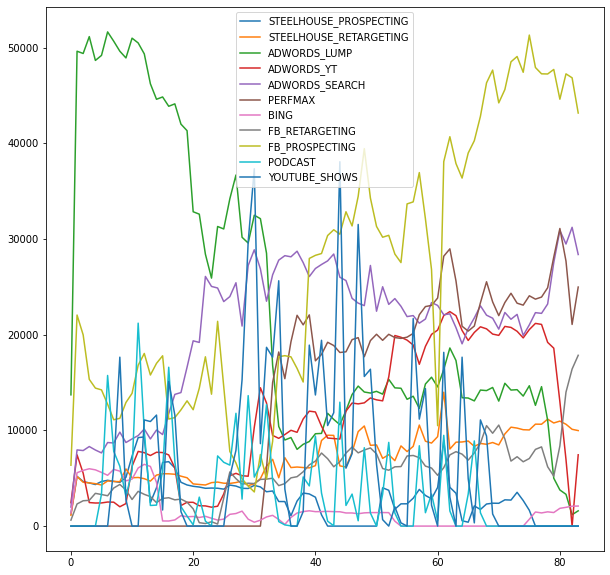

In [49]:
plt.rcParams["figure.figsize"] = (10,10)
df_s.drop(['SALES', 'DATE_AT'], axis=1).plot()
#plt.xlabel(list(df_s['DATE_AT'].dt.date.astype('str').values))
plt.show()

In [50]:
#sum of spend during change period
start = df_mod.iloc[start_ind, 0]
end = df_mod.iloc[end_ind, 0]

s = df_s.loc[(df_s['DATE_AT']>=start) & (df_s['DATE_AT']<=end), :]
s.fillna(0).sum().sort_values()

BING                        14576.980
STEELHOUSE_PROSPECTING      62027.220
PODCAST                     80423.571
FB_RETARGETING             215757.740
STEELHOUSE_RETARGETING     251058.410
YOUTUBE_SHOWS              251850.571
ADWORDS_LUMP               409139.871
ADWORDS_YT                 506903.011
PERFMAX                    624572.471
ADWORDS_SEARCH             663970.980
FB_PROSPECTING            1014310.220
SALES                    19692734.650
dtype: float64

In [51]:
start #change period start

Timestamp('2022-02-20 00:00:00')

In [52]:
end #change period end

Timestamp('2022-09-04 00:00:00')

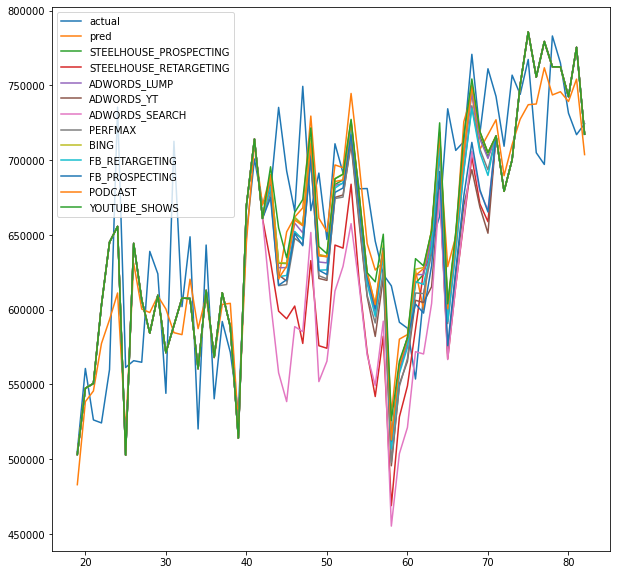

In [53]:
plt.rcParams["figure.figsize"] = (10,10)
mod_output.drop(['date', 'iter'], axis=1).plot()
plt.show()

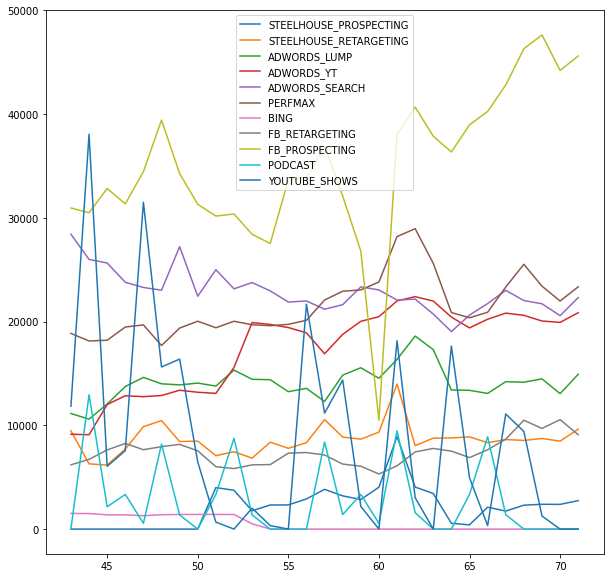

In [54]:
plt.rcParams["figure.figsize"] = (10,10)
s.drop(['SALES', 'DATE_AT'], axis=1).plot()
plt.show()

In [55]:
#calculation
roas = pd.DataFrame()
#spend hat
diff_s = s.fillna(0).sum()
diff_s = diff_s.drop('SALES')
for i in range(n):
    mod_output = scenario.loc[scenario['iter']==i, :].drop('iter', axis=1)
    #y hat
    diff = mod_output.drop('date', axis=1).sum()
    diff = diff['pred'] - diff
    diff = diff.drop(['actual', 'pred'])
    #roas
    roas_t = pd.DataFrame()
    roas_t['s_hat'] = diff_s
    roas_t['y_hat'] = diff
    roas_t['roas'] = roas_t['y_hat'] / roas_t['s_hat']
    roas_t['iter'] = i
    roas = roas.append(roas_t)
roas = roas.reset_index()
roas.columns = ['channel', 's_hat', 'y_hat', 'roas', 'iter']

In [56]:
roas_mean = roas.groupby('channel').mean().reset_index().sort_values('roas').drop('iter', axis=1)
roas_mean

,channel,s_hat,y_hat,roas
3,BING,14576.980,-243005.532,-16.670
8,STEELHOUSE_PROSPECTING,62027.220,-167760.438,-2.705
7,PODCAST,80423.571,-196397.082,-2.442
10,YOUTUBE_SHOWS,251850.571,-163464.573,-0.649
0,ADWORDS_LUMP,409139.871,-136979.476,-0.335
5,FB_RETARGETING,215757.740,37218.738,0.173
4,FB_PROSPECTING,1014310.220,220743.821,0.218
2,ADWORDS_YT,506903.011,346013.609,0.683
6,PERFMAX,624572.471,466580.852,0.747
1,ADWORDS_SEARCH,663970.980,983950.538,1.482


# Write results

In [57]:
#write beta df
current_GMT = time.gmtime()
ts = calendar.timegm(current_GMT)
beta_write = beta.copy(deep=True)
beta_write['timestamp'] = ts
beta_write.columns = map(lambda x: str(x).upper(), beta_write.columns)
write_pandas(con_w, beta_write, 'MMM_BETA')

(True,
 1,
 2200,
 [('rcltt/file0.txt', 'LOADED', 2200, 2200, 1, 0, None, None, None, None)])

In [58]:
#write metric df
metric_write = metric.copy(deep=True)
metric_write['timestamp'] = ts
metric_write.columns = map(lambda x: str(x).upper(), metric_write.columns)
write_pandas(con_w, metric_write, 'MMM_METRIC')

(True,
 1,
 200,
 [('jcqlm/file0.txt', 'LOADED', 200, 200, 1, 0, None, None, None, None)])

In [59]:
#write scenario data
scenario_write = scenario.copy(deep=True)
scenario_write['timestamp'] = ts
scenario_write['date'] = scenario_write['date'].astype('str')
scenario_write.columns = map(lambda x: str(x).upper(), scenario_write.columns)
write_pandas(con_w, scenario_write, 'MMM_SCENARIO')

(True,
 1,
 3200,
 [('nabdo/file0.txt', 'LOADED', 3200, 3200, 1, 0, None, None, None, None)])

In [60]:
#write roas df
roas_write = roas.copy(deep=True)
roas_write['timestamp'] = ts
roas_write.columns = map(lambda x: str(x).upper(), roas_write.columns)
write_pandas(con_w, roas_write, 'MMM_ROAS')

(True,
 1,
 550,
 [('uhzlc/file0.txt', 'LOADED', 550, 550, 1, 0, None, None, None, None)])

In [61]:
#write mean roas df
roas_mean_write = roas_mean.copy(deep=True)
roas_mean_write['timestamp'] = ts
roas_mean_write.columns = map(lambda x: str(x).upper(), roas_mean_write.columns)
write_pandas(con_w, roas_mean_write, 'MMM_ROAS_MEAN')

(True,
 1,
 11,
 [('pktrn/file0.txt', 'LOADED', 11, 11, 1, 0, None, None, None, None)])

# Marginal revenue calc

## 10%

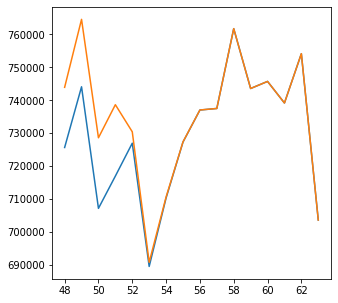

In [77]:
#get average monthly impressioan of each channel in the last 3 months
cols = ['DATE_AT', 'STEELHOUSE_PROSPECTING', 'STEELHOUSE_RETARGETING', 
        'ADWORDS_LUMP', 'ADWORDS_YT', 'ADWORDS_SEARCH', 'PERFMAX', 'BING', 'FB_RETARGETING', 'FB_PROSPECTING',
       'PODCAST', 'YOUTUBE_SHOWS']

avg_s = df.sort_values('DATE_AT').reset_index(drop=True)
avg_s = avg_s.iloc[-12:]
avg_s = avg_s.loc[:, cols].drop('DATE_AT', axis=1)
avg_s = avg_s.sum()
avg_s = avg_s/3

#marginal impression (per month)
avg_s_m = avg_s*0.10

#marginal impression (per week)
avg_s_d = avg_s_m / 4

#add weekly marginal impression over a month
df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
for ind,val in avg_s_d.iteritems():
    df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] = df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] + val
    
#transformation
df_fin = df_mod.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)

# tranform with final sat curve pick
df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)

# transform with final decay curve pick
df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)

#predict
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']
fin = linreg_opt.predict(x)

#eval
test_fin_10 = pd.DataFrame()
test_fin_10['pred_mod'] = fin
test_fin_10['pred'] = mod_output.reset_index()['pred']
test_fin_10['date'] = mod_output.reset_index()['date']
test_fin_10 = test_fin_10.iloc[-16:]

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(test_fin_10[['pred', 'pred_mod']], label=True)
plt.show()

## 20%

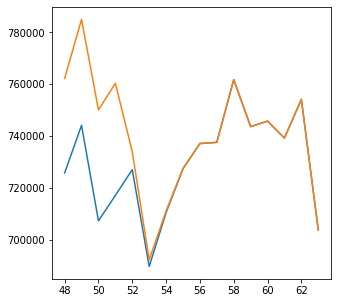

In [78]:
#get average monthly impression of each channel in the last 3 months
avg_s = df.sort_values('DATE_AT').reset_index(drop=True)
avg_s = avg_s.iloc[-12:]
avg_s = avg_s.loc[:, cols].drop('DATE_AT', axis=1)
avg_s = avg_s.sum()
avg_s = avg_s/3

#marginal impression (per month)
avg_s_m = avg_s*0.20

#marginal impression (per week)
avg_s_d = avg_s_m / 4

#add weekly marginal impression over a month
df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
for ind,val in avg_s_d.iteritems():
    df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] = df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] + val
    
#transformation
df_fin = df_mod.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)
# tranform with final sat curve pick
df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)
# transform with final decay curve pick
df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)
#predict
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']
fin = linreg_opt.predict(x)

#eval
test_fin_20 = pd.DataFrame()
test_fin_20['pred_mod'] = fin
test_fin_20['pred'] = mod_output.reset_index()['pred']
test_fin_20['date'] = mod_output.reset_index()['date']
test_fin_20 = test_fin_20.iloc[-16:]

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(test_fin_20[['pred', 'pred_mod']], label=True)
plt.show()

## 30%

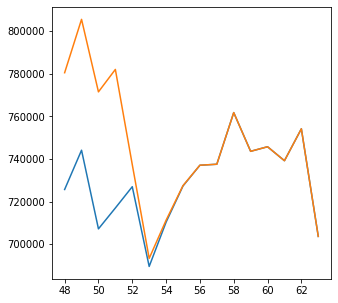

In [79]:
#get average monthly impression of each channel in the last 3 months
avg_s = df.sort_values('DATE_AT').reset_index(drop=True)
avg_s = avg_s.iloc[-12:]
avg_s = avg_s.loc[:, cols].drop('DATE_AT', axis=1)
avg_s = avg_s.sum()
avg_s = avg_s/3

#marginal impression (per month)
avg_s_m = avg_s*0.30

#marginal impression (per week)
avg_s_d = avg_s_m / 4

#add weekly marginal impression over a month
df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
for ind,val in avg_s_d.iteritems():
    df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] = df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] + val
    
#transformation
df_fin = df_mod.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)
# tranform with final sat curve pick
df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)

# transform with final decay curve pick
df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)
#predict
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']
fin = linreg_opt.predict(x)

#eval
test_fin_30 = pd.DataFrame()
test_fin_30['pred_mod'] = fin
test_fin_30['pred'] = mod_output.reset_index()['pred']
test_fin_30['date'] = mod_output.reset_index()['date']
test_fin_30 = test_fin_30.iloc[-16:]

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(test_fin_30[['pred', 'pred_mod']], label=True)
plt.show()

## 40%

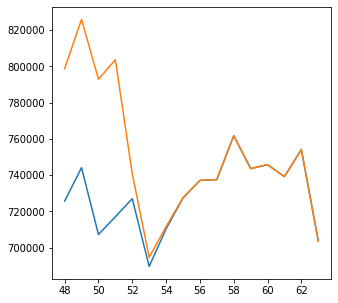

In [80]:
#get average monthly impression of each channel in the last 3 months
avg_s = df.sort_values('DATE_AT').reset_index(drop=True)
avg_s = avg_s.iloc[-12:]
avg_s = avg_s.loc[:, cols].drop('DATE_AT', axis=1)
avg_s = avg_s.sum()
avg_s = avg_s/3

#marginal impression (per month)
avg_s_m = avg_s*0.40

#marginal impression (per week)
avg_s_d = avg_s_m / 4

#add weekly marginal impression over a month
df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
for ind,val in avg_s_d.iteritems():
    df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] = df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] + val
    
#transformation
df_fin = df_mod.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)
# tranform with final sat curve pick
df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)

# transform with final decay curve pick
df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)
#predict
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']
fin = linreg_opt.predict(x)

#eval
test_fin_40 = pd.DataFrame()
test_fin_40['pred_mod'] = fin
test_fin_40['pred'] = mod_output.reset_index()['pred']
test_fin_40['date'] = mod_output.reset_index()['date']
test_fin_40 = test_fin_40.iloc[-16:]

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(test_fin_40[['pred', 'pred_mod']], label=True)
plt.show()

# 50%

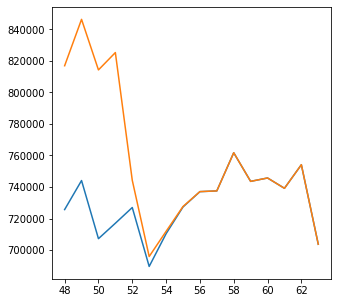

In [81]:
#get average monthly impression of each channel in the last 3 months
avg_s = df.sort_values('DATE_AT').reset_index(drop=True)
avg_s = avg_s.iloc[-12:]
avg_s = avg_s.loc[:, cols].drop('DATE_AT', axis=1)
avg_s = avg_s.sum()
avg_s = avg_s/3

#marginal impression (per month)
avg_s_m = avg_s*0.50

#marginal impression (per week)
avg_s_d = avg_s_m / 4

#add weekly marginal impression over a month
df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
for ind,val in avg_s_d.iteritems():
    df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] = df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] + val
    
#transformation
df_fin = df_mod.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)
# tranform with final sat curve pick
df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)

# transform with final decay curve pick
df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)
#predict
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']
fin = linreg_opt.predict(x)

#eval
test_fin_50 = pd.DataFrame()
test_fin_50['pred_mod'] = fin
test_fin_50['pred'] = mod_output.reset_index()['pred']
test_fin_50['date'] = mod_output.reset_index()['date']
test_fin_50 = test_fin_50.iloc[-16:]

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(test_fin_50[['pred', 'pred_mod']], label=True)
plt.show()

# 100%

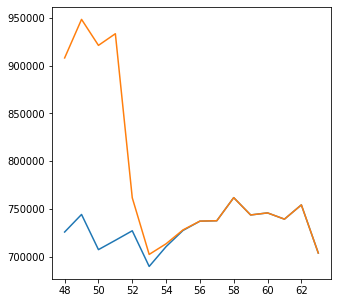

In [82]:
#get average monthly impression of each channel in the last 3 months
avg_s = df.sort_values('DATE_AT').reset_index(drop=True)
avg_s = avg_s.iloc[-12:]
avg_s = avg_s.loc[:, cols].drop('DATE_AT', axis=1)
avg_s = avg_s.sum()
avg_s = avg_s/3

#marginal impression (per month)
avg_s_m = avg_s*1.00

#marginal impression (per week)
avg_s_d = avg_s_m / 4

#add weekly marginal impression over a month
df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
for ind,val in avg_s_d.iteritems():
    df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] = df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] + val
    
#transformation
df_fin = df_mod.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)
# tranform with final sat curve pick
df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)

# transform with final decay curve pick
df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)
#predict
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']
fin = linreg_opt.predict(x)

#eval
test_fin_100 = pd.DataFrame()
test_fin_100['pred_mod'] = fin
test_fin_100['pred'] = mod_output.reset_index()['pred']
test_fin_100['date'] = mod_output.reset_index()['date']
test_fin_100 = test_fin_100.iloc[-16:]

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(test_fin_100[['pred', 'pred_mod']], label=True)
plt.show()

# 200%

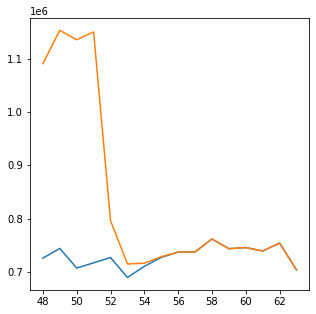

In [83]:
#get average monthly impression of each channel in the last 3 months
avg_s = df.sort_values('DATE_AT').reset_index(drop=True)
avg_s = avg_s.iloc[-12:]
avg_s = avg_s.loc[:, cols].drop('DATE_AT', axis=1)
avg_s = avg_s.sum()
avg_s = avg_s/3

#marginal impression (per month)
avg_s_m = avg_s*2.00

#marginal impression (per week)
avg_s_d = avg_s_m / 4

#add weekly marginal impression over a month
df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
for ind,val in avg_s_d.iteritems():
    df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] = df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] + val
    
#transformation
df_fin = df_mod.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)
# tranform with final sat curve pick
df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)

# transform with final decay curve pick
df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)
#predict
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']
fin = linreg_opt.predict(x)

#eval
test_fin_200 = pd.DataFrame()
test_fin_200['pred_mod'] = fin
test_fin_200['pred'] = mod_output.reset_index()['pred']
test_fin_200['date'] = mod_output.reset_index()['date']
test_fin_200 = test_fin_200.iloc[-16:]

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(test_fin_200[['pred', 'pred_mod']], label=True)
plt.show()

# 400%

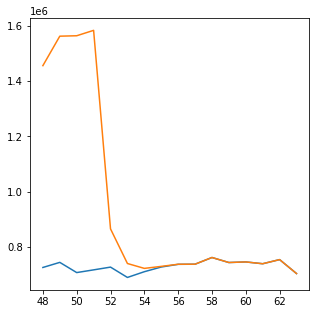

In [84]:
#get average monthly impression of each channel in the last 3 months
avg_s = df.sort_values('DATE_AT').reset_index(drop=True)
avg_s = avg_s.iloc[-12:]
avg_s = avg_s.loc[:, cols].drop('DATE_AT', axis=1)
avg_s = avg_s.sum()
avg_s = avg_s/3

#marginal impression (per month)
avg_s_m = avg_s*4.00

#marginal impression (per week)
avg_s_d = avg_s_m / 4

#add weekly marginal impression over a month
df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
for ind,val in avg_s_d.iteritems():
    df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] = df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] + val
    
#transformation
df_fin = df_mod.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)
# tranform with final sat curve pick
df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)

# transform with final decay curve pick
df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)
#predict
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']
fin = linreg_opt.predict(x)

#eval
test_fin_400 = pd.DataFrame()
test_fin_400['pred_mod'] = fin
test_fin_400['pred'] = mod_output.reset_index()['pred']
test_fin_400['date'] = mod_output.reset_index()['date']
test_fin_400 = test_fin_400.iloc[-16:]

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(test_fin_400[['pred', 'pred_mod']], label=True)
plt.show()

# 800%

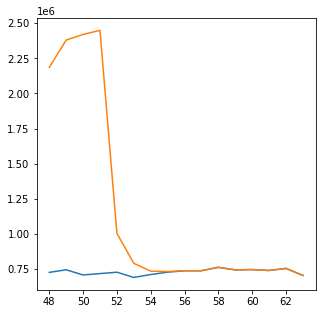

In [85]:
#get average monthly impression of each channel in the last 3 months
avg_s = df.sort_values('DATE_AT').reset_index(drop=True)
avg_s = avg_s.iloc[-12:]
avg_s = avg_s.loc[:, cols].drop('DATE_AT', axis=1)
avg_s = avg_s.sum()
avg_s = avg_s/3

#marginal impression (per month)
avg_s_m = avg_s*8.00

#marginal impression (per week)
avg_s_d = avg_s_m / 4

#add weekly marginal impression over a month
df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
for ind,val in avg_s_d.iteritems():
    df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] = df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] + val
    
#transformation
df_fin = df_mod.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)
# tranform with final sat curve pick
df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)

# transform with final decay curve pick
df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)
#predict
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']
fin = linreg_opt.predict(x)

#eval
test_fin_800 = pd.DataFrame()
test_fin_800['pred_mod'] = fin
test_fin_800['pred'] = mod_output.reset_index()['pred']
test_fin_800['date'] = mod_output.reset_index()['date']
test_fin_800 = test_fin_800.iloc[-16:]

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(test_fin_800[['pred', 'pred_mod']], label=True)
plt.show()

# 1600%

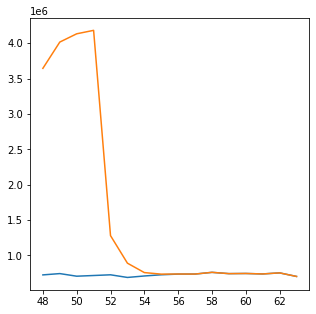

In [86]:
#get average monthly impression of each channel in the last 3 months
avg_s = df.sort_values('DATE_AT').reset_index(drop=True)
avg_s = avg_s.iloc[-12:]
avg_s = avg_s.loc[:, cols].drop('DATE_AT', axis=1)
avg_s = avg_s.sum()
avg_s = avg_s/3

#marginal impression (per month)
avg_s_m = avg_s*16.00

#marginal impression (per week)
avg_s_d = avg_s_m / 4

#add weekly marginal impression over a month
df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
for ind,val in avg_s_d.iteritems():
    df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] = df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] + val
    
#transformation
df_fin = df_mod.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)
# tranform with final sat curve pick
df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)

# transform with final decay curve pick
df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)
#predict
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']
fin = linreg_opt.predict(x)

#eval
test_fin_1600 = pd.DataFrame()
test_fin_1600['pred_mod'] = fin
test_fin_1600['pred'] = mod_output.reset_index()['pred']
test_fin_1600['date'] = mod_output.reset_index()['date']
test_fin_1600 = test_fin_1600.iloc[-16:]

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(test_fin_1600[['pred', 'pred_mod']], label=True)
plt.show()

# 3200%

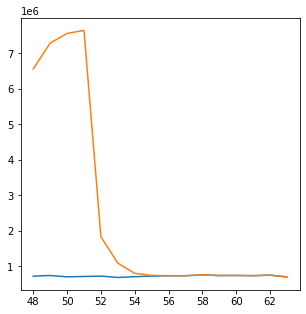

In [87]:
#get average monthly impression of each channel in the last 3 months
avg_s = df.sort_values('DATE_AT').reset_index(drop=True)
avg_s = avg_s.iloc[-12:]
avg_s = avg_s.loc[:, cols].drop('DATE_AT', axis=1)
avg_s = avg_s.sum()
avg_s = avg_s/3

#marginal impression (per month)
avg_s_m = avg_s*32.00

#marginal impression (per week)
avg_s_d = avg_s_m / 4

#add weekly marginal impression over a month
df_mod = df.sort_values('DATE_AT').reset_index(drop=True)
for ind,val in avg_s_d.iteritems():
    df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] = df_mod.iloc[-16:-12, df_mod.columns.get_loc(ind)] + val
    
#transformation
df_fin = df_mod.copy(deep=True)
df_fin = df_fin.sort_values('DATE_AT')
df_fin.drop('DATE_AT', axis=1, inplace=True)
# tranform with final sat curve pick
df_fin['BING'] = hill_transform(df_fin['BING'], 0.95, 1)
df_fin['YOUTUBE_SHOWS'] = hill_transform(df_fin['YOUTUBE_SHOWS'], 0.95, 2)
df_fin['IMPRESSIONS_ONLINE_PUBS'] = hill_transform(df_fin['IMPRESSIONS_ONLINE_PUBS'], 0.5, 0.5)
df_fin['SEARCH_INDEX'] = hill_transform(df_fin['SEARCH_INDEX'], 0.95, 1)
df_fin['LINKTREE_SESSION'] = hill_transform(df_fin['LINKTREE_SESSION'], 0.5, 0.5)
df_fin['SERP'] = hill_transform(df_fin['SERP'], 0.5, 0.5)

# transform with final decay curve pick
df_fin['PERFMAX'] = apply_adstock(df_fin['PERFMAX'], 8, 1, 0.3)
df_fin['BING'] = apply_adstock(df_fin['BING'], 8, 1, 0.3)
df_fin['FB_PROSPECTING'] = apply_adstock(df_fin['FB_PROSPECTING'], 8, 0, 0.8)
df_fin['PODCAST'] = apply_adstock(df_fin['PODCAST'], 8, 0, 0.8)
df_fin['IMPRESSIONS_BRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_BRANDED_SEARCH'], 8, 0, 0.3)
df_fin['IMPRESSIONS_NONBRANDED_SEARCH'] = apply_adstock(df_fin['IMPRESSIONS_NONBRANDED_SEARCH'], 8, 1.5, 0.8)
df_fin['SEARCH_INDEX'] = apply_adstock(df_fin['SEARCH_INDEX'], 8, 0, 0.3)
df_fin['LINKTREE_SESSION'] = apply_adstock(df_fin['LINKTREE_SESSION'], 8, 0, 0.8)
df_fin['SERP'] = apply_adstock(df_fin['SERP'], 8,  0, 0.8)
#predict
x = df_fin.drop(['SALES'], axis=1)
y = df_fin.loc[:, 'SALES']
fin = linreg_opt.predict(x)

#eval
test_fin_3200 = pd.DataFrame()
test_fin_3200['pred_mod'] = fin
test_fin_3200['pred'] = mod_output.reset_index()['pred']
test_fin_3200['date'] = mod_output.reset_index()['date']
test_fin_3200 = test_fin_3200.iloc[-16:]

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(test_fin_3200[['pred', 'pred_mod']], label=True)
plt.show()

In [88]:
marginal_rev = test_fin_10.copy(deep=True)
marginal_rev = marginal_rev[['date', 'pred', 'pred_mod']]
marginal_rev.columns = ['date', 'pred', 'pred_10']
marginal_rev['pred_20'] = test_fin_20['pred_mod']
marginal_rev['pred_30'] = test_fin_30['pred_mod']
marginal_rev['pred_40'] = test_fin_40['pred_mod']
marginal_rev['pred_50'] = test_fin_50['pred_mod']
marginal_rev['pred_100'] = test_fin_100['pred_mod']
marginal_rev['pred_200'] = test_fin_200['pred_mod']
marginal_rev['pred_400'] = test_fin_400['pred_mod']
marginal_rev['pred_800'] = test_fin_800['pred_mod']
marginal_rev['pred_1600'] = test_fin_1600['pred_mod']
marginal_rev['pred_3200'] = test_fin_3200['pred_mod']
marginal_rev

,date,pred,pred_10,pred_20,pred_30,pred_40,pred_50,pred_100,pred_200,pred_400,pred_800,pred_1600,pred_3200
48,2022-08-07,725690.223,743938.403,762186.602,780434.820,798683.056,816931.311,908172.856,1090657.228,1455630.552,2185592.063,3645556.046,6565572.680
49,2022-08-14,744108.433,764559.733,785011.116,805462.580,825914.124,846365.749,948625.043,1153149.182,1562217.315,2380417.982,4016996.816,7290538.710
50,2022-08-21,707231.455,728642.992,750054.631,771466.370,792878.208,814290.144,921351.268,1135480.348,1563762.945,2420407.400,4133914.773,7561402.412
51,2022-08-28,717019.013,738673.820,760328.729,781983.739,803638.849,825294.057,933571.549,1150133.398,1583281.658,2449657.839,4182629.772,7649048.923
52,2022-09-04,726996.807,730453.123,733909.522,737366.002,740822.564,744279.207,761563.597,796137.963,865306.674,1003708.898,1280691.957,1835044.700
53,2022-09-11,689612.280,690872.142,692132.025,693391.927,694651.847,695911.787,702211.764,714813.032,740020.275,790450.025,891351.595,1093245.802
54,2022-09-18,710379.269,710679.467,710979.666,711279.866,711580.066,711880.266,713381.276,716383.331,722387.564,734396.433,758415.280,806455.373
55,2022-09-25,727339.469,727396.429,727453.389,727510.349,727567.309,727624.269,727909.069,728478.669,729617.870,731896.271,736453.077,745566.695
56,2022-10-02,737059.155,737066.426,737073.697,737080.968,737088.239,737095.511,737131.867,737204.579,737350.003,737640.851,738222.547,739385.940
57,2022-10-09,737529.137,737529.741,737530.346,737530.950,737531.554,737532.158,737535.179,737541.221,737553.304,737577.471,737625.806,737722.474


# Write results

In [92]:
current_GMT = time.gmtime()
ts = calendar.timegm(current_GMT)

In [93]:
#write scenario data
marginal_rev_write = marginal_rev.copy(deep=True)
marginal_rev_write['timestamp'] = ts
marginal_rev_write['date'] = marginal_rev_write['date'].astype('str')
marginal_rev_write.columns = map(lambda x: str(x).upper(), marginal_rev_write.columns)
write_pandas(con_w, marginal_rev_write, 'MMM_MARGINAL_REV')

(True,
 1,
 16,
 [('yhnzp/file0.txt', 'LOADED', 16, 16, 1, 0, None, None, None, None)])

In [94]:
#write dates
start_m = df_mod.iloc[-16, 0].strftime("%Y-%m-%d")
stop_m = df_mod.iloc[-12, 0].strftime("%Y-%m-%d")
start_r = start.strftime("%Y-%m-%d")
stop_r = end.strftime("%Y-%m-%d")
start_df = df['DATE_AT'].min().strftime("%Y-%m-%d")
stop_df = df['DATE_AT'].max().strftime("%Y-%m-%d")
rundate = today_a
d = {'START_': start_m
     , 'STOP_': stop_m
     , 'START_ROAS': start_r
     , 'STOP_ROAS': stop_r
     , 'RUNDATE': rundate
     , 'START_DF': start_df
     , 'STOP_DF': stop_df
     , 'TIMESTAMP': ts}
dates_write = pd.DataFrame(d, index=[0])
write_pandas(con_w, dates_write, 'MMM_DATES')

(True,
 1,
 1,
 [('qeyjy/file0.txt', 'LOADED', 1, 1, 1, 0, None, None, None, None)])

In [95]:
dates_write

,START_,STOP_,START_ROAS,STOP_ROAS,RUNDATE,START_DF,STOP_DF,TIMESTAMP
0,2022-08-07,2022-09-04,2022-02-20,2022-09-04,2022-12-21,2021-09-05,2022-11-20,1671656522
